In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 20})
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
Nor_path = "./Dataset/Normal_mixed.csv"
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
                "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
Nor_df = pd.read_csv(Nor_path, header=None,names= col_names, nrows= 100000)

In [3]:
Abnor_path = "./Dataset/Abnormal.csv"
Abnor_df = pd.read_csv(Abnor_path, header=None,names= col_names, nrows= 100000)

In [4]:
Kdd_path = "./Dataset/kdd99_extracted.csv"
kdd99_df = pd.read_csv(Kdd_path, header=None,names= col_names, nrows= 200000)

In [5]:
kdd99_nor = kdd99_df[kdd99_df['label'] == 'Normal']
kdd99_abnor = kdd99_df[kdd99_df['label'] != 'Normal']

In [4]:
Train = pd.concat([Nor_df.iloc[:8000],Abnor_df.iloc[:8000]], ignore_index=True)
Train_nor = Nor_df.iloc[:8000]
#Train_abnor = pd.concat([Abnor_df.iloc[:8000], kdd99_abnor.iloc[:4000]], ignore_index=True)
Train_abnor = Abnor_df.iloc[:8000]

Test = pd.concat([Nor_df.iloc[-2000:], Abnor_df.iloc[-2000:]], ignore_index=True)
Test_nor = Nor_df.iloc[-2000:]
Test_abnor = Abnor_df.iloc[-2000:]

# Test_kdd = pd.concat([kdd99_nor.iloc[:2000],kdd99_abnor.iloc[:2000]], ignore_index=True)
# Test_nor_kdd = kdd99_nor.iloc[:2000]
# Test_abnor_kdd = kdd99_abnor.iloc[:2000]


In [5]:
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler()

In [6]:
def preprocess(df, is_fit=True):
    # chuyển normal thành 1 và các lớp khác thành 0
    label = df['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)

    # loại bỏ cột dữ liệu không cần thiết
    df.drop(["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"], axis=1)

    # chia dữ liệu ra số, chữ để tiện xử lý
    numerical_data = df.select_dtypes(exclude='object').values
    categorical_data = df.select_dtypes(include='object').values

    # chỉ fit với dữ liệu train
    if is_fit:
        encoder.fit(categorical_data)

    # chuyển từ dữ liệu chữ sang onehot
    categorical_data = encoder.transform(categorical_data).toarray()

    # nối dữ liệu số và onehot lại
    data = np.concatenate([numerical_data, categorical_data], axis=1)

    # chỉ fit với dữ liệu train
    if is_fit:
        scaler.fit(data)

    # dữ liệu chuẩn hóa về dạng [0, 1]
    data = scaler.transform(data)

    return dict(data=data, label=label)

In [7]:
# xử lý dữ liệu
train = preprocess(Train, True)
test = preprocess(Test, False)
#test_kdd = preprocess(Test_kdd, False)
#test_v1 = preprocess(Test_v1, False)
#test_v2 = preprocess(Test_v2,False)

In [8]:
train['data'].shape, test['data'].shape

((16000, 51), (4000, 51))

In [9]:
# chia dữ liệu
Train_nor = train['data'][train['label'] == 'Normal']
Train_abnor = train['data'][train['label'] == 'Abnormal']

Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

# kdd_nor = test_kdd['data'][test_kdd['label'] == 'Normal']
# kdd_abnor = test_kdd['data'][test_kdd['label'] == 'Abnormal']

In [10]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(48, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(8, activation='tanh')
    ])
    self.decoder = keras.Sequential([
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(48, activation='tanh'),
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(input_dim, activation='sigmoid'),
    ])

  def call(self, x):
    code = self.encoder(x)
    r = self.decoder(code)
    return r

  def get_reconstruction_error(self, x):
    r = self.predict(x)
    return keras.metrics.mean_squared_error(x, r)

  def predict_class(self, x, threshold):
    reconstruction_error = self.get_reconstruction_error(x)
    return np.where(reconstruction_error <= threshold, 'Normal', 'Abnormal')

In [11]:
model = Autoencoder(Train_nor.shape[1])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer, loss_fn)

In [12]:
model.fit(Train_nor, Train_nor, batch_size=64, epochs=200, shuffle=True)

Epoch 1/200
125/125 [==============================] - 2s 2ms/step - loss: 0.2000
Epoch 2/200
125/125 [==============================] - 0s 2ms/step - loss: 0.1215
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0774
Epoch 4/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0615
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0558
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0533
Epoch 7/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0519
Epoch 8/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0507
Epoch 9/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0483
Epoch 10/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0452
Epoch 11/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 12/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0384
Epoch 13/200


In [13]:
train_normal_re = model.get_reconstruction_error(Train_nor)
train_abnormal_re = model.get_reconstruction_error(Train_abnor)

test_normal_re = model.get_reconstruction_error(Test_nor)
test_abnormal_re = model.get_reconstruction_error(Test_abnor)

# kdd_nor_re = model.get_reconstruction_error(kdd_nor)
# kdd_abnor_re = model.get_reconstruction_error(kdd_abnor)

63/63 [==============================] - 0s 1ms/step


In [14]:
alpha = 0.5
threshold = np.concatenate([train_normal_re, train_abnormal_re]).mean() * alpha
print('Ngưỡng vừa tìm được từ tập train:', threshold)

Ngưỡng vừa tìm được từ tập train: 0.028154021129012108


In [15]:
label_predict = model.predict_class(train['data'], threshold)
print('Độ chính xác tập huấn luyện', end=': ')
print(accuracy_score(train['label'], label_predict))

label_predict = model.predict_class(test['data'], threshold)
print('Độ chính xác tập test', end=': ')
print(accuracy_score(test['label'], label_predict))

# label_predict = model.predict_class(test_kdd['data'], threshold)
# print('Độ chính xác tập kdd', end=': ')
# print(accuracy_score(test_kdd['label'], label_predict))

191/500 [==========>...................] - ETA: 0s

500/500 [==============================] - 1s 1ms/step
Độ chính xác tập huấn luyện: 0.9990625
125/125 [==============================] - 0s 1ms/step
Độ chính xác tập test: 0.99775


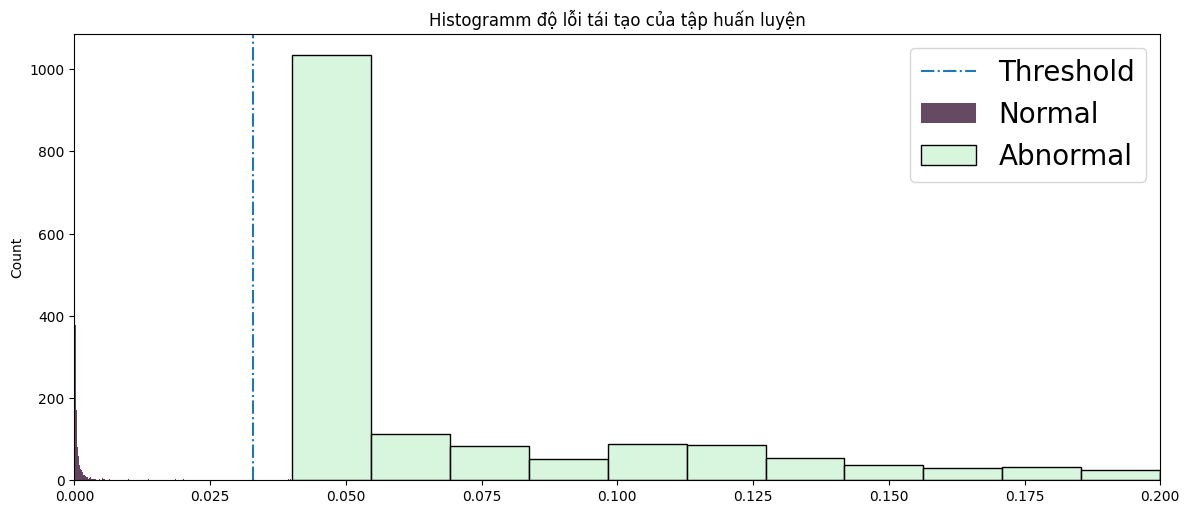

In [16]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=test_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=test_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.2])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện')
plt.show()

# Reinforcement Learning A2C threshold adaption


In [15]:
from sklearn.cluster import KMeans

def get_clustering_based_reward(reconstruction_error):
    kmeans = KMeans(n_clusters=2,n_init=10, random_state=0)
    reconstruction_error_np = reconstruction_error.numpy()
    kmeans.fit(reconstruction_error_np.reshape(-1,1))
    labels = kmeans.labels_
    reward = np.mean(reconstruction_error[labels == 0]) - np.mean(reconstruction_error[labels == 1])
    return reward

In [16]:
test_data = test['data']
reconstruction_error = model.get_reconstruction_error(test_data)

# Đặt threshold sai
wrong_threshold = 4 * threshold

initial_prediction = model.predict_class(test_data, wrong_threshold)
print("Initial Threshold:", wrong_threshold)
print(accuracy_score(test['label'], initial_prediction))

125/125 [==============================] - 0s 1ms/step
Initial Threshold: 0.11261608451604843
0.62475


In [17]:
# Mô hình A2C
optimizer_actor = keras.optimizers.Adam(learning_rate=0.001)
optimizer_critic = keras.optimizers.Adam(learning_rate=0.001)

actor = keras.Sequential([
    keras.layers.Dense(1, activation='sigmoid')
])
critic = keras.Sequential([
    keras.layers.Dense(1, input_shape=(1,))  
])


In [19]:

for epoch in range(200):
    # Chuẩn bị dữ liệu clustering
    reward = get_clustering_based_reward(reconstruction_error)

    # Thực hiện một bước gradient ascent cho Actor
    with tf.GradientTape() as tape_actor:
        action = actor(test_data)
    grads_actor = tape_actor.gradient(action, actor.trainable_variables)
    optimizer_actor.apply_gradients(zip(grads_actor, actor.trainable_variables))

    # Thực hiện một bước gradient descent cho Critic
    with tf.GradientTape() as tape_critic:
        critic_value = critic(reconstruction_error)
        critic_loss = keras.losses.mean_squared_error(reward, critic_value)
    grads_critic = tape_critic.gradient(critic_loss, critic.trainable_variables)
    optimizer_critic.apply_gradients(zip(grads_critic, critic.trainable_variables))

    # Lưu lại giá trị threshold sau mỗi bước tối ưu hóa
    optimized_threshold = actor(test_data).numpy()[0][0] * wrong_threshold

    # Hiển thị thông tin về quá trình huấn luyện
    print("Epoch:", epoch, "Critic Loss:", critic_loss.numpy(), "Optimized Threshold:", optimized_threshold)

# Đánh giá lại hiệu suất với threshold đã được tối ưu
print("Optimized threshold:",optimized_threshold)
optimized_prediction = model.predict_class(test_data, optimized_threshold)
print(accuracy_score(test['label'], optimized_prediction))


Epoch: 0 Critic Loss: [0.14890558 0.14904824 0.14981622 ... 0.27622706 0.21151412 0.31139657] Optimized Threshold: 0.055645997488035226
Epoch: 1 Critic Loss: [0.1481975  0.1483397  0.14910528 ... 0.2751539  0.21061976 0.3102303 ] Optimized Threshold: 0.055394666889174715
Epoch: 2 Critic Loss: [0.14749189 0.14763364 0.14839685 ... 0.27408403 0.2097283  0.30906752] Optimized Threshold: 0.05514368533728331
Epoch: 3 Critic Loss: [0.14678875 0.14693007 0.14769088 ... 0.27301738 0.20883967 0.30790812] Optimized Threshold: 0.054893069613465295
Epoch: 4 Critic Loss: [0.14608805 0.14622892 0.14698738 ... 0.2719539  0.20795391 0.3067522 ] Optimized Threshold: 0.05464283985504581
Epoch: 5 Critic Loss: [0.14538983 0.14553027 0.14628634 ... 0.2708937  0.20707104 0.30559963] Optimized Threshold: 0.054392996062024856
Epoch: 6 Critic Loss: [0.14469405 0.14483404 0.14558776 ... 0.26983672 0.20619096 0.30445057] Optimized Threshold: 0.054143568440390144
Epoch: 7 Critic Loss: [0.14400071 0.14414027 0.144